# Targets ... of UN Sustainable Development Goals
## Data preprocessing and visualisation

In this notebook, we preprocess and visualise data of the *targets* of United Nations Sustainable Development Goals. For each of these targets, at least one quantitatively measurable *indicator* is defined. The total number of targets is 169; of those, data for 83 are given by the UN Statistics Division.

**Background to data**: It represents the entire world

### Import the required packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import pystan_utils
import os

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

### Use pandas to load the data set

In [2]:
# load csv
#os.chdir('/home/felix/PycharmProjects/MBMLproject')
df = pd.read_csv("SDG_Indicators.csv")
df.head()

,Goal,Target,Indicator Ref,IndicatorId,Indicator Description,Series Code,Series Type,Series Description,Parent Country or Area Code,Country or Area Code,...,2013,FN.30,2014,FN.31,2015,FN.32,2016,FN.33,2017,FN.34
0,1,1.1,1.1.1,C010101,Proportion of population below the internation...,SI_POV_DAY1,SD,Proportion of population below the internation...,NaN,MDG_WORLD,...,10.70,"24, 70",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.1,1.1.1,C010101,Proportion of population below the internation...,SI_POV_EMP1,SD,Proportion of employed population below the in...,NaN,MDG_WORLD,...,16.45,"M, 24, 72",15.87,"M, 25, 72",15.51,"M, 26, 72",15.10,"M, 27, 72",NaN,NaN
2,1,1.1,1.1.1,C010101,Proportion of population below the internation...,SI_POV_EMP1,SD,Proportion of employed population below the in...,NaN,MDG_WORLD,...,16.37,"M, 24, 72",15.83,"M, 25, 72",15.54,"M, 26, 72",15.18,"M, 27, 72",NaN,NaN
3,1,1.1,1.1.1,C010101,Proportion of population below the internation...,SI_POV_EMP1,SD,Proportion of employed population below the in...,NaN,MDG_WORLD,...,16.50,"M, 24, 72",15.89,"M, 25, 72",15.49,"M, 26, 72",15.04,"M, 27, 72",NaN,NaN
4,1,1.1,1.1.1,C010101,Proportion of population below the internation...,SI_POV_EMP1,SD,Proportion of employed population below the in...,NaN,MDG_WORLD,...,11.14,"M, 24, 72",10.61,"M, 25, 72",10.25,"M, 26, 72",9.87,"M, 27, 72",NaN,NaN


### Modify df to focus on columns of use

Display columns

In [3]:
df.columns

Index(['Goal', 'Target', 'Indicator Ref', 'IndicatorId',
       'Indicator Description', 'Series Code', 'Series Type',
       'Series Description', 'Parent Country or Area Code',
       'Country or Area Code', 'Country or Area Name', 'LDC', 'LLDC', 'SIDS',
       'Frequency', 'Source type', 'Age group', 'Location', 'Sex',
       'Value type', 'Unit', 'Unit multiplier', '1983', 'FN', '1984', 'FN.1',
       '1985', 'FN.2', '1986', 'FN.3', '1987', 'FN.4', '1988', 'FN.5', '1989',
       'FN.6', '1990', 'FN.7', '1991', 'FN.8', '1992', 'FN.9', '1993', 'FN.10',
       '1994', 'FN.11', '1995', 'FN.12', '1996', 'FN.13', '1997', 'FN.14',
       '1998', 'FN.15', '1999', 'FN.16', '2000', 'FN.17', '2001', 'FN.18',
       '2002', 'FN.19', '2003', 'FN.20', '2004', 'FN.21', '2005', 'FN.22',
       '2006', 'FN.23', '2007', 'FN.24', '2008', 'FN.25', '2009', 'FN.26',
       '2010', 'FN.27', '2011', 'FN.28', '2012', 'FN.29', '2013', 'FN.30',
       '2014', 'FN.31', '2015', 'FN.32', '2016', 'FN.33', '2017'

In [4]:
df.describe()

,Goal,Parent Country or Area Code,LDC,LLDC,SIDS,1983,1984,FN.1,1985,1986,...,1988,FN.5,1989,1991,1992,1993,1994,1996,1997,1999
count,299.000000,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,3.000000,0.0,...,0.0,0.0,3.000000,3.000000,6.000000,6.000000,6.000000,6.000000,9.000000,7.000000
mean,7.672241,NaN,NaN,NaN,NaN,33.336667,NaN,NaN,33.333333,NaN,...,NaN,NaN,33.333333,48.200000,23.583333,14.611667,37.210000,27.341667,77.948889,36.674286
std,5.428572,NaN,NaN,NaN,NaN,18.147543,NaN,NaN,16.119157,NaN,...,NaN,NaN,8.259845,61.588311,13.360255,23.243360,79.044737,55.043911,187.464333,66.865561
min,1.000000,NaN,NaN,NaN,NaN,16.670000,NaN,NaN,18.180000,NaN,...,NaN,NaN,26.840000,7.000000,7.000000,0.820000,0.820000,0.810000,0.810000,0.800000
25%,3.000000,NaN,NaN,NaN,NaN,23.670000,NaN,NaN,24.865000,NaN,...,NaN,NaN,28.685000,12.800000,16.625000,0.822500,0.820000,0.820000,0.820000,0.810000
50%,6.000000,NaN,NaN,NaN,NaN,30.670000,NaN,NaN,31.550000,NaN,...,NaN,NaN,30.530000,18.600000,21.635000,3.915000,2.910000,3.410000,16.100000,15.300000
75%,12.000000,NaN,NaN,NaN,NaN,41.670000,NaN,NaN,40.910000,NaN,...,NaN,NaN,36.580000,68.800000,28.152500,15.400000,14.600000,13.950000,26.630000,26.500000
max,17.000000,NaN,NaN,NaN,NaN,52.670000,NaN,NaN,50.270000,NaN,...,NaN,NaN,42.630000,119.000000,45.950000,60.000000,198.000000,139.000000,576.000000,186.000000


Delete the columns of no use.
Decided to drop all years before 2005 as they only have very few data points.

In [5]:
df1 = df.drop(['IndicatorId', 'Series Code', 'Series Type',
             'Series Description', 'Parent Country or Area Code',
             'Country or Area Code', 'Country or Area Name', 'LDC', 'LLDC', 'SIDS',
             'Frequency', 'Source type', 'Location', '1983', 'FN', '1984', 'FN.1',
               '1985', 'FN.2', '1986', 'FN.3', '1987', 'FN.4', '1988', 'FN.5', '1989',
               'FN.6', '1990', 'FN.7', '1991', 'FN.8', '1992', 'FN.9', '1993', 'FN.10',
               '1994', 'FN.11', '1995', 'FN.12', '1996', 'FN.13', '1997', 'FN.14',
               '1998', 'FN.15', '1999', 'FN.16', '2000', 'FN.17', '2001', 'FN.18',
               '2002', 'FN.19', '2003', 'FN.20', '2004', 'FN.21','FN.22','FN.23','FN.24',
               'FN.25','FN.26','FN.27','FN.28','FN.29','FN.30','FN.31','FN.32','FN.33','FN.34',
              ], axis=1)

In [6]:
df1.head(100)

,Goal,Target,Indicator Ref,Indicator Description,Age group,Sex,Value type,Unit,Unit multiplier,2005,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,1.1,1.1.1,Proportion of population below the internation...,All age ranges or no breakdown by age,Both sexes or no breakdown by sex,NaN,Percent,Units,NaN,...,NaN,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN
1,1,1.1,1.1.1,Proportion of population below the internation...,15 to 24 years old,Both sexes or no breakdown by sex,NaN,Percent,Units,24.80,...,22.04,21.18,20.22,18.26,17.08,16.45,15.87,15.51,15.10,NaN
2,1,1.1,1.1.1,Proportion of population below the internation...,15 to 24 years old,Female,NaN,Percent,Units,24.82,...,21.83,20.84,19.84,18.04,16.98,16.37,15.83,15.54,15.18,NaN
3,1,1.1,1.1.1,Proportion of population below the internation...,15 to 24 years old,Male,NaN,Percent,Units,24.78,...,22.18,21.41,20.47,18.40,17.15,16.50,15.89,15.49,15.04,NaN
4,1,1.1,1.1.1,Proportion of population below the internation...,15 years old and over,Both sexes or no breakdown by sex,NaN,Percent,Units,18.69,...,16.35,15.51,14.62,12.89,11.77,11.14,10.61,10.25,9.87,NaN
5,1,1.1,1.1.1,Proportion of population below the internation...,15 years old and over,Female,NaN,Percent,Units,18.62,...,15.98,15.00,14.05,12.53,11.58,11.00,10.56,10.26,9.93,NaN
6,1,1.1,1.1.1,Proportion of population below the internation...,15 years old and over,Male,NaN,Percent,Units,18.74,...,16.60,15.84,14.99,13.12,11.90,11.23,10.65,10.25,9.84,NaN
7,1,1.1,1.1.1,Proportion of population below the internation...,25 years old and over,Both sexes or no breakdown by sex,NaN,Percent,Units,17.31,...,15.14,14.34,13.50,11.84,10.77,10.17,9.68,9.34,8.99,NaN
8,1,1.1,1.1.1,Proportion of population below the internation...,25 years old and over,Female,NaN,Percent,Units,17.21,...,14.72,13.78,12.89,11.46,10.56,10.02,9.62,9.35,9.05,NaN
9,1,1.1,1.1.1,Proportion of population below the internation...,25 years old and over,Male,NaN,Percent,Units,17.38,...,15.41,14.70,13.90,12.09,10.91,10.27,9.72,9.34,8.95,NaN


In [7]:
df1.columns

Index(['Goal', 'Target', 'Indicator Ref', 'Indicator Description', 'Age group',
       'Sex', 'Value type', 'Unit', 'Unit multiplier', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017'],
      dtype='object')

- "Goal" defining the overall goal
- "Target" measurable target
- "Indicator Ref" 
- year indicating in which year the measure was taken
- 'Age group'
- 'Sex'
- 'Value type'
- 'Unit'
- 'Unit multiplier'
- "Indicator Description" - description of the target

Select the rows that display data of 
    
1. *all* age groups and sex
2. are *not* lower or upper bound
3. 

@Galina: as you can see in the following cell, some rows have merely one data point. We can do that and plot different categories in a histogram; or we take the rows with the most data points and plot each row over time. The former has more use for our intentions later on, whereas the latter would perhaps look nicer (?). I lean toward the the former. *(The next few cells will help you understanding what I mean with categories)*
    

In [8]:
# all age groups
df2 = df1[df1['Age group'].isin(['All age ranges or no breakdown by age'])]
df3 = df2.drop(['Age group'], axis=1)

# all sex
df4 = df3[df3['Sex'].isin(['Both sexes or no breakdown by sex'])]
df5 = df4.drop(['Sex'], axis=1)

# not lower or upper bound
df6 = df5[~df5['Value type'].isin(['Lower bound', 'Upper bound'])]

# uncomment to check
df6.head(20)


,Goal,Target,Indicator Ref,Indicator Description,Value type,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,1.1,1.1.1,Proportion of population below the internation...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN
10,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
11,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
12,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
13,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN
14,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.93,NaN
15,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.77,NaN
16,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.72,NaN
17,2,2.1,2.1.1,Prevalence of undernourishment,NaN,Percent,Units,14.70,14.30,13.70,13.00,12.50,12.10,11.80,11.40,11.20,11.00,10.80,NaN,NaN
48,2,2.5,2.5.1,Number of plant and animal genetic resources f...,NaN,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"11,616.00",NaN,NaN,NaN,NaN


In [9]:
df6

,Goal,Target,Indicator Ref,Indicator Description,Value type,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,1.1,1.1.1,Proportion of population below the internation...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN
10,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
11,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
12,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
13,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN
14,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.93,NaN
15,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.77,NaN
16,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.72,NaN
17,2,2.1,2.1.1,Prevalence of undernourishment,NaN,Percent,Units,14.70,14.30,13.70,13.00,12.50,12.10,11.80,11.40,11.20,11.00,10.80,NaN,NaN
48,2,2.5,2.5.1,Number of plant and animal genetic resources f...,NaN,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"11,616.00",NaN,NaN,NaN,NaN


### Sort data by different units

ind = df6['Indicator Description'].unique()
for i in ind:
    print(i)

*Issue*: data is given in percentage, per 1000, 10000, in tonnes CO2eq, in kilometres, etc. (see above output)

*Idea*: organise data into different categories, display in **another** graph environmental (i.e. taking CO2 eq), display in **another** graph distance, etc.

In [10]:
# Trying out some stuff
df6[df6['Unit'].isin(['Kilometres'])]['Indicator Description']

189    Passenger and freight volumes, by mode of tran...
191    Passenger and freight volumes, by mode of tran...
196    Passenger and freight volumes, by mode of tran...
Name: Indicator Description, dtype: object

In [11]:
# show all units
units = df6.Unit.unique()
for u in units:
    print(u)
    print(df6[df6['Unit'].isin([u])]['Indicator Description'].unique())
    print('------------------------------------------------------------------------------------')

Percent
['Proportion of population below the international poverty line, by sex, age, employment status and geographical location (urban/rural)'
 'Proportion of population covered by social protection floors/systems, by sex, distinguishing children, unemployed persons, older persons, persons with disabilities, pregnant women, newborns, work-injury victims and the poor and the vulnerable'
 'Prevalence of undernourishment'
 'Number of plant and animal genetic resources for food and agriculture secured in either medium or long-term conservation facilities'
 'Proportion of local breeds classified as being at risk, not-at-risk or at unknown level of risk of extinction'
 'Proportion of births attended by skilled health personnel'
 'Participation rate in organized learning (one year before the official primary entry age), by sex'
 'Proportion of population using safely managed drinking water services'
 'Proportion of population using safely managed sanitation services, including a hand-washin

In [12]:
#df6[df['Indicator Description'].isin(['Red List Index'])]

# Create Dataframes of different categories

In [13]:
# import csv file
indicator_categories = pd.read_csv('Dev_Indicators.csv', delimiter=';')
indicator_categories.head()
del indicator_categories['Unnamed: 2']
del indicator_categories['Unnamed: 3']
indicator_categories.head()

,Category,Indicator Description
0,----,"Number of verified cases of killing, kidnappin..."
1,E&P (Percent),Number of countries that have national statist...
2,E&P (Percent),Number of countries with a national statistica...
3,E&P (Percent),Energy intensity measured in terms of primary ...
4,E&P (Percent),Annual growth rate of real GDP per capita


In [14]:
df6['Indicator Description']

0      Proportion of population below the internation...
10     Proportion of population covered by social pro...
11     Proportion of population covered by social pro...
12     Proportion of population covered by social pro...
13     Proportion of population covered by social pro...
14     Proportion of population covered by social pro...
15     Proportion of population covered by social pro...
16     Proportion of population covered by social pro...
17                        Prevalence of undernourishment
48     Number of plant and animal genetic resources f...
49     Number of plant and animal genetic resources f...
50     Number of plant and animal genetic resources f...
51     Number of plant and animal genetic resources f...
52     Number of plant and animal genetic resources f...
53     Number of plant and animal genetic resources f...
54     Number of plant and animal genetic resources f...
55     Proportion of local breeds classified as being...
56     Proportion of local bree

In [15]:
ind_cat_joined = indicator_categories.merge(df6, on='Indicator Description')
ind_cat_joined.head()

,Category,Indicator Description,Goal,Target,Indicator Ref,Value type,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,----,"Number of verified cases of killing, kidnappin...",16,16.10,16.10.1,NaN,Number,Units,NaN,NaN,...,NaN,NaN,65.00,62.00,124.00,90.00,98.00,115.00,102.00,NaN
1,E&P (Percent),Number of countries that have national statist...,17,17.18,17.18.2,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.00,NaN
2,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN
3,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,NaN
4,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,NaN


In [16]:
ind_cat_joined['Category'].unique()

array(['----', 'E&P (Percent)', 'E&P (percent)', 'E&P (USD)',
       'Environment (Percent)', 'Environment (percent)',
       'Environment (Tonnes)', 'Population', 'Population (Percent)',
       '---'], dtype=object)

## Population dataframe

In [17]:
df_population = ind_cat_joined[ind_cat_joined['Category'].str.contains('Population')]
df_population['Unit'].unique()

array(['Percent', 'Per 100,000 live births',
       'Per 1,000 uninfected population', 'Per 100,000 population',
       'Per 1,000 population', 'Number', 'Per million population'],
      dtype=object)

In [18]:
df_population[df_population['Unit'].str.contains('Number')]['Indicator Description'].unique()

array(['Suicide mortality rate',
       'Degree of integrated water resources management implementation (0-100)',
       'Number of victims of intentional homicide per 100,000 population, by sex and age'],
      dtype=object)

In [19]:
df_population[df_population['Indicator Description'].str.contains('Suicide mortality rate')] # can remove the number value for suicide mortality rate

,Category,Indicator Description,Goal,Target,Indicator Ref,Value type,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
109,Population,Suicide mortality rate,3,3.4,3.4.2,NaN,"Per 100,000 population",Units,11.61,NaN,...,NaN,NaN,11.23,NaN,NaN,NaN,NaN,10.73,NaN,NaN
110,Population,Suicide mortality rate,3,3.4,3.4.2,NaN,Number,Thousands,756.72,NaN,...,NaN,NaN,777.95,NaN,NaN,NaN,NaN,788.09,NaN,NaN


In [20]:
year = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017']

In [21]:
def popToPercent(unit, n):
    if type(n)==float:
        n2 = n
    elif n.find(',') != -1:
        n = n.replace(',','')
    n2 = float(n)
    if np.isnan(n2):
        return np.nan
    if unit =='Percent':
        return n2
    if unit == 'Per 1,000 population' or 'Per 1,000 uninfected population':
        return n2/10
    if unit == 'Per 100,000 population':
        return n2/1000

In [22]:
df_pop_soon_percent = df_population[~df_population['Unit'].isin(['Number'])]

In [23]:
df_pop_to_percent = df_pop_soon_percent.copy()
for yr in year:
    #df_pop_to_percent[yr] = df_pop_to_percent.apply(lambda r: r[yr].replace(',',''), axis=1)
    df_pop_to_percent[yr] = df_pop_to_percent.apply(lambda r: popToPercent(r['Unit'], r[yr]), axis=1)
df_pop_to_percent['Unit'] = 'Percent'

In [24]:
df_pop_number = df_population[df_population['Unit'].isin(['Number'])]
df_pop_number = df_pop_number[~df_pop_number['Indicator Description'].str.contains('Suicide mortality rate')] # got that covered
#note: All the ones that are covered here, are already expressed in other units, s.a. percent or per 100,000 population, so we can just ignore these values

## Economy and Politics

In [25]:
df_ecopol = ind_cat_joined[ind_cat_joined['Category'].str.contains('E&P')]
df_ecopol

,Category,Indicator Description,Goal,Target,Indicator Ref,Value type,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,E&P (Percent),Number of countries that have national statist...,17,17.18,17.18.2,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.00,NaN
2,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN
3,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,NaN
4,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,NaN
5,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.00,NaN
6,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.00,NaN
7,E&P (Percent),Energy intensity measured in terms of primary ...,7,7.3,7.3.1,NaN,Megajoules per USD constant 2011 PPP GDP,Units,6.37,NaN,...,NaN,NaN,5.95,NaN,NaN,NaN,5.49,NaN,NaN,NaN
8,E&P (Percent),Annual growth rate of real GDP per capita,8,8.1,8.1.1,NaN,Percent,Units,2.35,2.77,...,0.20,-3.24,2.82,1.62,1.01,1.08,1.35,1.45,NaN,NaN
9,E&P (Percent),Annual growth rate of real GDP per employed pe...,8,8.2,8.2.1,NaN,Percent,Units,2.77,3.85,...,1.83,-0.71,4.07,2.66,1.90,1.93,1.80,1.67,1.80,NaN
10,E&P (Percent),Manufacturing value added as a proportion of G...,9,9.2,9.2.1,NaN,Percent,Units,15.28,15.61,...,15.74,14.99,15.81,15.97,15.94,15.99,16.03,16.11,16.16,NaN


In [26]:
df_ecopol.Category.unique()

array(['E&P (Percent)', 'E&P (percent)', 'E&P (USD)'], dtype=object)

In [27]:
for el in df_ecopol['Indicator Description'].unique():
    print (el)

Number of countries that have national statistical legislation that complies with the Fundamental Principles of Official Statistics
Number of countries with a national statistical plan that is fully funded and under implementation, by source of funding
Energy intensity measured in terms of primary energy and GDP
Annual growth rate of real GDP per capita
Annual growth rate of real GDP per employed person
Manufacturing value added as a proportion of GDP and per capita
Research and development expenditure as a proportion of GDP
Remittance costs as a proportion of the amount remitted
Direct economic loss in relation to global GDP, damage to critical infrastructure and number of disruptions to basic services, attributed to disasters
Proportion of businesses that had at least one contact with a public official and that paid a bribe to a public official, or were asked for a bribe by those public officials during the previous 12 months
Net official development assistance, total and to least de

In [28]:
df_ecopol['Unit'].unique()

array(['Number', 'Megajoules per USD constant 2011 PPP GDP', 'Percent',
       'Constant USD', 'Per 1,000 USD', 'USD', 'Not applicable'],
      dtype=object)

## Create E&P Dataframe with unit Percent

In [29]:
df_ecopol_percent = df_ecopol[df_ecopol['Unit'].isin(['Percent'])]
df_ecopol_percent

,Category,Indicator Description,Goal,Target,Indicator Ref,Value type,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
8,E&P (Percent),Annual growth rate of real GDP per capita,8,8.1,8.1.1,NaN,Percent,Units,2.35,2.77,...,0.20,-3.24,2.82,1.62,1.01,1.08,1.35,1.45,NaN,NaN
9,E&P (Percent),Annual growth rate of real GDP per employed pe...,8,8.2,8.2.1,NaN,Percent,Units,2.77,3.85,...,1.83,-0.71,4.07,2.66,1.90,1.93,1.80,1.67,1.80,NaN
10,E&P (Percent),Manufacturing value added as a proportion of G...,9,9.2,9.2.1,NaN,Percent,Units,15.28,15.61,...,15.74,14.99,15.81,15.97,15.94,15.99,16.03,16.11,16.16,NaN
12,E&P (Percent),Research and development expenditure as a prop...,9,9.5,9.5.1,NaN,Percent,Units,1.53,1.54,...,1.60,1.64,1.62,1.64,1.65,1.68,1.69,NaN,NaN,NaN
13,E&P (Percent),Remittance costs as a proportion of the amount...,10,10.c,10.c.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,8.90,9.00,8.60,8.20,7.50,NaN,NaN
19,E&P (Percent),Proportion of businesses that had at least one...,16,16.5,16.5.2,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.35,NaN
21,E&P (Percent),Volume of remittances (in United States dollar...,17,17.3,17.3.2,NaN,Percent,Units,0.54,0.58,...,0.65,0.66,0.65,0.65,0.67,0.69,0.71,0.76,NaN,NaN
22,E&P (Percent),Extent of use of country-owned results framewo...,17,17.15,17.15.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.89
23,E&P (Percent),Extent of use of country-owned results framewo...,17,17.15,17.15.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.60
24,E&P (Percent),Extent of use of country-owned results framewo...,17,17.15,17.15.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.46


In [30]:
df_ecopol_to_percent = df_ecopol[~df_ecopol['Unit'].isin(['Percent'])]
df_ecopol_to_percent

,Category,Indicator Description,Goal,Target,Indicator Ref,Value type,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,E&P (Percent),Number of countries that have national statist...,17,17.18,17.18.2,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.00,NaN
2,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN
3,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.00,NaN
4,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00,NaN
5,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.00,NaN
6,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Number,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.00,NaN
7,E&P (Percent),Energy intensity measured in terms of primary ...,7,7.3,7.3.1,NaN,Megajoules per USD constant 2011 PPP GDP,Units,6.37,NaN,...,NaN,NaN,5.95,NaN,NaN,NaN,5.49,NaN,NaN,NaN
11,E&P (Percent),Manufacturing value added as a proportion of G...,9,9.2,9.2.1,NaN,Constant USD,Units,"1,355.32","1,426.52",...,"1,490.66","1,380.79","1,500.07","1,543.94","1,559.71","1,582.69","1,611.65","1,638.06","1,660.80",NaN
14,E&P (Percent),Direct economic loss in relation to global GDP...,11,11.5,11.5.2,NaN,"Per 1,000 USD",Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.81,NaN
15,E&P (Percent),Direct economic loss in relation to global GDP...,11,11.5,11.5.2,NaN,USD,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"293,995.47",NaN


In [31]:
# find these that describe number of countries and divide these by number of UN member countries*100
df_ecopol_to_percent_no_countries = df_ecopol_to_percent[df_ecopol_to_percent['Indicator Description'].str.contains('Number of countries')]

for yr in year:
    df_ecopol_to_percent_no_countries[yr] = df_ecopol_to_percent_no_countries.apply(lambda r: float(r[yr])/1.93, axis=1)
df_ecopol_to_percent_no_countries['Unit'] = 'Percent'

df_ecopol_to_percent_no_countries

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Category,Indicator Description,Goal,Target,Indicator Ref,Value type,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,E&P (Percent),Number of countries that have national statist...,17,17.18,17.18.2,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.170984,NaN
2,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.145078,NaN
3,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.326425,NaN
4,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.626943,NaN
5,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.808290,NaN
6,E&P (Percent),Number of countries with a national statistica...,17,17.18,17.18.3,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.968912,NaN
28,E&P (Percent),Number of countries reporting progress in mult...,17,17.16,17.16.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.834197


In [32]:
df_ecopol_percent1 = df_ecopol_percent.append(df_ecopol_to_percent_no_countries)
df_ecopol_percent1

,Category,Indicator Description,Goal,Target,Indicator Ref,Value type,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
8,E&P (Percent),Annual growth rate of real GDP per capita,8,8.1,8.1.1,NaN,Percent,Units,2.35,2.77,...,0.20,-3.24,2.82,1.62,1.01,1.08,1.35,1.45,NaN,NaN
9,E&P (Percent),Annual growth rate of real GDP per employed pe...,8,8.2,8.2.1,NaN,Percent,Units,2.77,3.85,...,1.83,-0.71,4.07,2.66,1.90,1.93,1.80,1.67,1.80,NaN
10,E&P (Percent),Manufacturing value added as a proportion of G...,9,9.2,9.2.1,NaN,Percent,Units,15.28,15.61,...,15.74,14.99,15.81,15.97,15.94,15.99,16.03,16.11,16.16,NaN
12,E&P (Percent),Research and development expenditure as a prop...,9,9.5,9.5.1,NaN,Percent,Units,1.53,1.54,...,1.60,1.64,1.62,1.64,1.65,1.68,1.69,NaN,NaN,NaN
13,E&P (Percent),Remittance costs as a proportion of the amount...,10,10.c,10.c.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,8.90,9.00,8.60,8.20,7.50,NaN,NaN
19,E&P (Percent),Proportion of businesses that had at least one...,16,16.5,16.5.2,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.35,NaN
21,E&P (Percent),Volume of remittances (in United States dollar...,17,17.3,17.3.2,NaN,Percent,Units,0.54,0.58,...,0.65,0.66,0.65,0.65,0.67,0.69,0.71,0.76,NaN,NaN
22,E&P (Percent),Extent of use of country-owned results framewo...,17,17.15,17.15.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.89
23,E&P (Percent),Extent of use of country-owned results framewo...,17,17.15,17.15.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.60
24,E&P (Percent),Extent of use of country-owned results framewo...,17,17.15,17.15.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.46


## Create E&P Dataframe with unit USD

In [33]:
df_ecopol_to_usd = df_ecopol[df_ecopol['Unit'].str.contains('USD') & ~df_ecopol['Unit'].str.contains('Megajoules')]
df_ecopol_to_usd

,Category,Indicator Description,Goal,Target,Indicator Ref,Value type,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
11,E&P (Percent),Manufacturing value added as a proportion of G...,9,9.2,9.2.1,NaN,Constant USD,Units,"1,355.32","1,426.52",...,"1,490.66","1,380.79","1,500.07","1,543.94","1,559.71","1,582.69","1,611.65","1,638.06","1,660.80",NaN
14,E&P (Percent),Direct economic loss in relation to global GDP...,11,11.5,11.5.2,NaN,"Per 1,000 USD",Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.81,NaN
15,E&P (Percent),Direct economic loss in relation to global GDP...,11,11.5,11.5.2,NaN,USD,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"293,995.47",NaN
18,E&P (Percent),Direct economic loss in relation to global GDP...,11,11.5,11.5.2,NaN,USD,Millions,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"279,582,450.28",NaN
20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,NaN,Constant USD,Billions,"115,298.66","109,093.83",...,"112,241.65","114,280.76","120,630.26","119,673.34","115,307.60","121,838.28","123,945.78","131,555.31","143,328.70",NaN
36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,NaN,USD,Units,NaN,"162,618,473.30",...,"247,953,598.40","140,684,730.40","351,996,221.80","483,067,124.00","208,600,838.50","443,106,234.30","349,844,367.50",NaN,NaN,NaN


In [34]:
def toUSD(unit, multiplier, n):
    if type(n)==float:
        n2 = n
    elif n.find(',') != -1:
        n = n.replace(',','')
    n2 = float(n)
    if np.isnan(n2):
        return np.nan
    if unit=='Constant USD' or unit=='USD':
        if multiplier=='Units':
            return n2
        if multiplier=='Millions':
            return n2/1000000
        if multiplier=='Billions':
            return n2/1000000000
    elif unit=='Per 1,000 USD':
        return n2/1000

In [35]:
for yr in year:
    df_ecopol_to_usd[yr] = df_ecopol_to_usd.apply(lambda r: toUSD(r['Unit'], r['Unit multiplier'], r[yr]), axis=1)
df_ecopol_to_usd

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Category,Indicator Description,Goal,Target,Indicator Ref,Value type,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
11,E&P (Percent),Manufacturing value added as a proportion of G...,9,9.2,9.2.1,NaN,Constant USD,Units,1355.320000,1.426520e+03,...,1.490660e+03,1.380790e+03,1.500070e+03,1.543940e+03,1.559710e+03,1.582690e+03,1.611650e+03,1638.060000,1660.800000,NaN
14,E&P (Percent),Direct economic loss in relation to global GDP...,11,11.5,11.5.2,NaN,"Per 1,000 USD",Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003810,NaN
15,E&P (Percent),Direct economic loss in relation to global GDP...,11,11.5,11.5.2,NaN,USD,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293995.470000,NaN
18,E&P (Percent),Direct economic loss in relation to global GDP...,11,11.5,11.5.2,NaN,USD,Millions,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279.582450,NaN
20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,NaN,Constant USD,Billions,0.000115,1.090938e-04,...,1.122416e-04,1.142808e-04,1.206303e-04,1.196733e-04,1.153076e-04,1.218383e-04,1.239458e-04,0.000132,0.000143,NaN
36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,NaN,USD,Units,NaN,1.626185e+08,...,2.479536e+08,1.406847e+08,3.519962e+08,4.830671e+08,2.086008e+08,4.431062e+08,3.498444e+08,NaN,NaN,NaN


*OBS!*: Did not manage to include Agriculture Orientation Index (it is a value between 0 and 1, so we might want to include it in the percent dataframe after multiplying it by 100) and energy intensity (it's in MJ and I don't remember if/how we planned to convert it)

## Environment

In [36]:
df_environment = ind_cat_joined[ind_cat_joined['Category'].str.contains('Environment')]
df_environment.head()

,Category,Indicator Description,Goal,Target,Indicator Ref,Value type,Unit,Unit multiplier,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
37,Environment (Percent),Level of water stress: freshwater withdrawal a...,6,6.4,6.4.2,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.70,NaN,NaN,NaN
38,Environment (Percent),Renewable energy share in the total final ener...,7,7.2,7.2.1,NaN,Percent,Units,16.91,16.97,...,17.14,17.71,17.51,17.54,17.91,18.19,18.33,NaN,NaN,NaN
39,Environment (percent),Proportion of urban solid waste regularly coll...,11,11.6,11.6.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.20
40,Environment (percent),Number of parties to international multilatera...,12,12.4,12.4.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.46,NaN,NaN
41,Environment (percent),Number of parties to international multilatera...,12,12.4,12.4.1,NaN,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,NaN,NaN


In [37]:
df_environment['Unit'].unique()

array(['Percent', 'Square kilometers', 'Hectares', 'Metric Tons',
       'Not applicable', 'Number', 'Kilograms', 'Tonne kilometres',
       'Kilometres', 'kg CO2 equivalent per USD1 constant 2005 PPP GDP',
       'Kilograms per constant USD', 'Micrograms per cubic meter',
       'Tonnes per hectare'], dtype=object)

# *Notes from the first trial, might be ignored, but I keep it here just in case ;)*

## category 1: all indicators which measure proportion of population

In [38]:
# show all rows which contain the word 'population in its description
df_p1 = df6[df6['Indicator Description'].str.contains('population')]
df_p1

,Goal,Target,Indicator Ref,Indicator Description,Value type,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,1.1,1.1.1,Proportion of population below the internation...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN
10,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
11,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
12,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
13,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN
14,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.93,NaN
15,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.77,NaN
16,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.72,NaN
72,3,3.3,3.3.1,"Number of new HIV infections per 1,000 uninfec...",NaN,"Per 1,000 uninfected population",Units,0.40,NaN,NaN,NaN,NaN,0.33,NaN,NaN,NaN,NaN,0.30,NaN,NaN
76,3,3.3,3.3.2,"Tuberculosis incidence per 100,000 population",NaN,"Per 100,000 population",Units,169.00,166.00,164.00,161.00,159.00,155.00,153.00,150.00,147.00,144.00,142.00,NaN,NaN


### bring all numbers to percent

In [39]:
# do not consider the rows which are already in percentage
df_p2 = df_p1[df_p1['Unit'].isin(['Percent'])]
df_p2

,Goal,Target,Indicator Ref,Indicator Description,Value type,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,1.1,1.1.1,Proportion of population below the internation...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN
10,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
11,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
12,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
13,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN
14,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.93,NaN
15,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.77,NaN
16,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.72,NaN
124,6,6.1,6.1.1,Proportion of population using safely managed ...,NaN,Percent,Units,47.97,49.46,50.98,52.49,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN
125,6,6.1,6.1.1,Proportion of population using safely managed ...,NaN,Percent,Units,66.09,67.06,68.02,68.97,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN


In [40]:
# see if the rows containing 'population', but are not measured in percentage, contain information
df_p3 = df_p1[~df_p1['Unit'].isin(['Percent'])]
df_p3

,Goal,Target,Indicator Ref,Indicator Description,Value type,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
72,3,3.3,3.3.1,"Number of new HIV infections per 1,000 uninfec...",NaN,"Per 1,000 uninfected population",Units,0.40,NaN,NaN,NaN,NaN,0.33,NaN,NaN,NaN,NaN,0.30,NaN,NaN
76,3,3.3,3.3.2,"Tuberculosis incidence per 100,000 population",NaN,"Per 100,000 population",Units,169.00,166.00,164.00,161.00,159.00,155.00,153.00,150.00,147.00,144.00,142.00,NaN,NaN
79,3,3.3,3.3.3,"Malaria incidence per 1,000 population",NaN,"Per 1,000 population",Units,141.25,NaN,NaN,NaN,NaN,118.74,NaN,NaN,NaN,NaN,93.95,NaN,NaN
216,11,11.6,11.6.2,Annual mean levels of fine particulate matter ...,NaN,Micrograms per cubic meter,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.47,NaN,NaN,NaN,NaN,NaN
217,11,11.6,11.6.2,Annual mean levels of fine particulate matter ...,NaN,Micrograms per cubic meter,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.05,NaN,NaN,NaN,NaN,NaN
256,16,16.1,16.1.1,Number of victims of intentional homicide per ...,NaN,"Per 100,000 population",Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.34,NaN,NaN
257,16,16.1,16.1.1,Number of victims of intentional homicide per ...,NaN,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"387,433.30",NaN,NaN
294,17,17.19,17.19.2,Proportion of countries that (a) have conducte...,NaN,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.00,NaN,NaN
296,17,17.19,17.19.2,Proportion of countries that (a) have conducte...,NaN,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.00,NaN
298,17,17.19,17.19.2,Proportion of countries that (a) have conducte...,NaN,Number,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.00,NaN,NaN


In [41]:
set(df_p3['Unit'])

{'Micrograms per cubic meter',
 'Number',
 'Per 1,000 population',
 'Per 1,000 uninfected population',
 'Per 100,000 population'}

In [42]:
# the rows with Units as 'Micrograms per cubic meter' or 'Number' do not want to be considered either
df_p4 = df_p3[~df_p3['Unit'].isin(['Micrograms per cubic meter', 'Number'])]
df_p4

,Goal,Target,Indicator Ref,Indicator Description,Value type,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
72,3,3.3,3.3.1,"Number of new HIV infections per 1,000 uninfec...",NaN,"Per 1,000 uninfected population",Units,0.40,NaN,NaN,NaN,NaN,0.33,NaN,NaN,NaN,NaN,0.30,NaN,NaN
76,3,3.3,3.3.2,"Tuberculosis incidence per 100,000 population",NaN,"Per 100,000 population",Units,169.00,166.00,164.00,161.00,159.00,155.00,153.00,150.00,147.00,144.00,142.00,NaN,NaN
79,3,3.3,3.3.3,"Malaria incidence per 1,000 population",NaN,"Per 1,000 population",Units,141.25,NaN,NaN,NaN,NaN,118.74,NaN,NaN,NaN,NaN,93.95,NaN,NaN
256,16,16.1,16.1.1,Number of victims of intentional homicide per ...,NaN,"Per 100,000 population",Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.34,NaN,NaN


In [43]:
df_p4.columns

Index(['Goal', 'Target', 'Indicator Ref', 'Indicator Description',
       'Value type', 'Unit', 'Unit multiplier', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

In [44]:
# continue here
# change the unit of those rows to percentage
years = ['1983', '1984', '1985', '1986','1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017']
def toPercent(unit, n):
    if np.isnan(n): # does not work!
        return np.nan
    n = float(n)
    if unit == 'Per 1,000 population' or 'Per 1,000 uninfected population':
        return n/1000
    elif unit == 'Per 100,000 population':
        return n/100000

In [45]:
year

['2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017']

In [46]:
df_to_percent = df_p4.copy()
    
for y in year:
    df_to_percent[y] = df_p4.apply(lambda r: toPercent(r['Unit'], float(r[y])), axis=1)
df_to_percent['Unit'] = 'Percent'

df_to_percent

,Goal,Target,Indicator Ref,Indicator Description,Value type,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
72,3,3.3,3.3.1,"Number of new HIV infections per 1,000 uninfec...",NaN,Percent,Units,0.00040,NaN,NaN,NaN,NaN,0.00033,NaN,NaN,NaN,NaN,0.00030,NaN,NaN
76,3,3.3,3.3.2,"Tuberculosis incidence per 100,000 population",NaN,Percent,Units,0.16900,0.166,0.164,0.161,0.159,0.15500,0.153,0.15,0.147,0.144,0.14200,NaN,NaN
79,3,3.3,3.3.3,"Malaria incidence per 1,000 population",NaN,Percent,Units,0.14125,NaN,NaN,NaN,NaN,0.11874,NaN,NaN,NaN,NaN,0.09395,NaN,NaN
256,16,16.1,16.1.1,Number of victims of intentional homicide per ...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00534,NaN,NaN


In [47]:
df_p4

,Goal,Target,Indicator Ref,Indicator Description,Value type,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
72,3,3.3,3.3.1,"Number of new HIV infections per 1,000 uninfec...",NaN,"Per 1,000 uninfected population",Units,0.40,NaN,NaN,NaN,NaN,0.33,NaN,NaN,NaN,NaN,0.30,NaN,NaN
76,3,3.3,3.3.2,"Tuberculosis incidence per 100,000 population",NaN,"Per 100,000 population",Units,169.00,166.00,164.00,161.00,159.00,155.00,153.00,150.00,147.00,144.00,142.00,NaN,NaN
79,3,3.3,3.3.3,"Malaria incidence per 1,000 population",NaN,"Per 1,000 population",Units,141.25,NaN,NaN,NaN,NaN,118.74,NaN,NaN,NaN,NaN,93.95,NaN,NaN
256,16,16.1,16.1.1,Number of victims of intentional homicide per ...,NaN,"Per 100,000 population",Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.34,NaN,NaN


In [48]:
df_p_combined_percent = df_p2.append(df_to_percent)
df_p_combined_percent = df_p_combined_percent.reset_index()
df_p_combined_percent = df_p_combined_percent.drop(['index'], axis=1)
df_p_combined_percent

,Goal,Target,Indicator Ref,Indicator Description,Value type,Unit,Unit multiplier,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,1.1,1.1.1,Proportion of population below the internation...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN
1,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN
5,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.93,NaN
6,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.77,NaN
7,1,1.3,1.3.1,Proportion of population covered by social pro...,NaN,Percent,Units,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.72,NaN
8,6,6.1,6.1.1,Proportion of population using safely managed ...,NaN,Percent,Units,47.97,49.46,50.98,52.49,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN
9,6,6.1,6.1.1,Proportion of population using safely managed ...,NaN,Percent,Units,66.09,67.06,68.02,68.97,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN


In [49]:
df_p_combined_percent.describe()
# why does this give the wrong counts?

,Goal
count,32.000000
mean,6.531250
std,5.117865
min,1.000000
25%,2.500000
50%,6.000000
75%,7.500000
max,17.000000


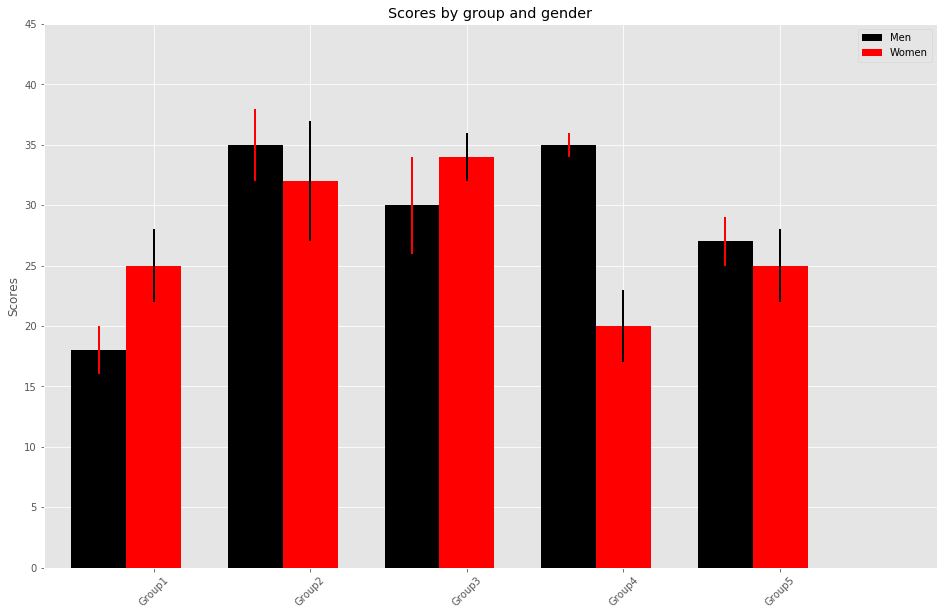

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)

N=5
## the data
menMeans = [18, 35, 30, 35, 27]
menStd =   [2, 3, 4, 1, 2]
womenMeans = [25, 32, 34, 20, 25]
womenStd =   [3, 5, 2, 3, 3]

## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, menMeans, width,
                color='black',
                yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))

rects2 = ax.bar(ind+width, womenMeans, width,
                    color='red',
                    yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,45)
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
xTickMarks = ['Group'+str(i) for i in range(1,6)]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

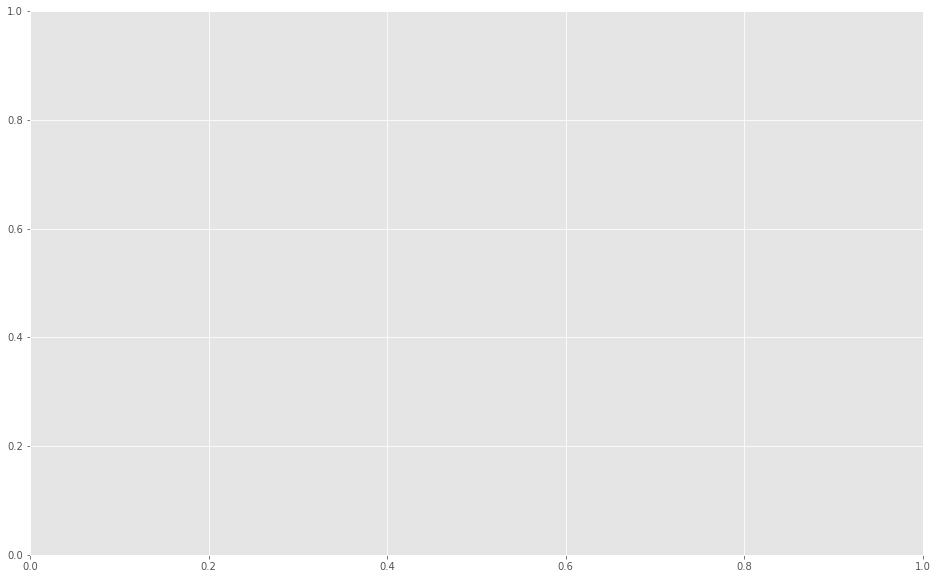

In [51]:
fig1 = plt.figure()
ax = fig1.add_subplot(111)

## the data
# TODO: take out every target for the years

## necessary variables
ind = years                # years: x-location for groups
width = 0.25                      # the width of the bars

## the bars
# HOW TO VISUALIZE? IT IS A BIT TOO MUCH TO PUT THEM ALL IN ONE PLOT....
rects1 = ax.bar(ind, menMeans, width,
                color='black',
                yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))

rects2 = ax.bar(ind+width, womenMeans, width,
                    color='red',
                    yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,45)
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
xTickMarks = ['Group'+str(i) for i in range(1,6)]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('Men', 'Women') )

plt.show()

In [ ]:
vis_percent.hist(by='Indicator Ref')

http://people.duke.edu/~ccc14/pcfb/numpympl/MatplotlibBarPlots.html
https://matplotlib.org/devdocs/gallery/api/two_scales.html

*perhaps good* in the very end: descriptive statistics

In [ ]:
# define different dfx for different units
dfx1.describe()
dfx2.describe()
...
df6.describe()

In [ ]:
# TODO: Fill the gaps with inference
# TODO: Structure Learning